In [2]:
## import libraries
import os, sys
import yaml
import xarray as xr
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import dask
from datetime import timedelta
import glob
%matplotlib inline

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import textwrap

# import personal modules
sys.path.append('../modules')
import ar_funcs
import custom_cmaps as ccmap
from plotter import draw_basemap
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [9]:
## load all lead times
mon = 11
day = 17

## load mclimate data
fname_pattern = path_to_data + 'preprocessed/mclimate/GEFSv12_reforecast_mclimate_ivt_{0}{1}_*hr-lead.nc'.format(mon, day)
print(fname_pattern)
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', concat_dim="step", combine='nested')
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'}) # need to rename this to match GEFSv12 Reforecast
ds = ds.sortby("step") # sort by step (forecast lead)
ds

/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/mclimate/GEFSv12_reforecast_mclimate_ivt_1117_*hr-lead.nc


<xarray.Dataset>
Dimensions:    (lat: 281, lon: 479, dayofyear: 1, step: 40, quantile: 13)
Coordinates:
  * lat        (lat) float64 70.0 69.75 69.5 69.25 69.0 ... 0.75 0.5 0.25 0.0
  * lon        (lon) float64 -179.5 -179.2 -179.0 -178.8 ... -60.5 -60.25 -60.0
  * quantile   (quantile) float64 0.0 0.75 0.9 0.91 0.92 ... 0.97 0.98 0.99 1.0
  * step       (step) int64 6 12 18 24 30 36 42 ... 204 210 216 222 228 234 240
  * dayofyear  (dayofyear) int64 321
Data variables:
    ivt        (dayofyear, step, quantile, lat, lon) float64 dask.array<chunksize=(1, 1, 13, 281, 479), meta=np.ndarray>

In [10]:
step = ds.step.values
forecast_lst = []
for i, st in enumerate(step):
    fname = path_to_data + 'downloads/GFS_025d/GFS_IVT_2023111700_F{0}.nc'.format(st)

    ## load the forecast    
    forecast = xr.open_dataset(fname)
    forecast = forecast.rename({'lon_0': 'lon', 'lat_0': 'lat'}) # need to rename this to match GEFSv12 Reforecast
    forecast = forecast.assign_coords({"lon": (((forecast.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
    forecast = forecast.sel(lon=slice(-179.5, -110.))
    forecast = forecast.drop_vars(["uIVT", "vIVT"])
    forecast_lst.append(forecast)

forecast = xr.concat(forecast_lst, pd.Index(step, name="step"))
forecast

<xarray.Dataset>
Dimensions:  (step: 40, lat: 241, lon: 279)
Coordinates:
  * lat      (lat) float32 10.0 10.25 10.5 10.75 11.0 ... 69.25 69.5 69.75 70.0
  * lon      (lon) float32 -179.5 -179.2 -179.0 -178.8 ... -110.5 -110.2 -110.0
  * step     (step) int64 6 12 18 24 30 36 42 48 ... 204 210 216 222 228 234 240
Data variables:
    IVT      (step, lat, lon) float32 226.6 218.6 217.0 ... 34.82 35.2 35.55

In [11]:
def get_lat_lons_from_txt_file(textpts_fname):
    ## read text file with points
    df = pd.read_csv(textpts_fname, header=None, sep=' ', names=['latitude', 'longitude'], engine='python')
    df['longitude'] = df['longitude']*-1
    df = df
    lons = df['longitude'].values
    lats = df['latitude'].values

    x = xr.DataArray(lons, dims=['location'])
    y = xr.DataArray(lats, dims=['location'])

    return x, y

In [12]:
## select transect points
x, y = get_lat_lons_from_txt_file('../data/latlon_coast.txt')
ds = ds.sel(lon=x, lat=y, method='nearest')
forecast = forecast.sel(lon=x, lat=y, method='nearest')
## apply below loop to transect points only

In [13]:
%%time
ds = ds.load()
forecast = forecast.load()

CPU times: user 475 ms, sys: 775 ms, total: 1.25 s
Wall time: 4.53 s


In [14]:
ds

<xarray.Dataset>
Dimensions:    (location: 71, dayofyear: 1, step: 40, quantile: 13)
Coordinates:
    lat        (location) float64 54.0 55.0 55.0 55.0 ... 54.5 54.0 54.0 54.0
    lon        (location) float64 -130.0 -130.5 -131.0 ... -164.0 -164.5 -165.0
  * quantile   (quantile) float64 0.0 0.75 0.9 0.91 0.92 ... 0.97 0.98 0.99 1.0
  * step       (step) int64 6 12 18 24 30 36 42 ... 204 210 216 222 228 234 240
  * dayofyear  (dayofyear) int64 321
Dimensions without coordinates: location
Data variables:
    ivt        (dayofyear, step, quantile, location) float64 0.06704 ... 933.5

In [18]:
bottom = ds.ivt.isel(quantile=0.75) # minimum threshold
b = xr.where(cond=forecast.IVT < bottom, x=0.75, y=np.nan)
b

TypeError: invalid indexer array, does not have integer dtype: array(0.75)

In [17]:
## compare IVT forecast to mclimate
b_lst = []
quant_lst = [0  , 0.75, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]
for i, quant in enumerate(quant_lst):
    bottom = ds.ivt.isel(quantile=quant) # minimum threshold
    
    if i == 0:
        # only need to see where IVT in the forecast is less than minimum quantile
        b = xr.where(cond=forecast.IVT < bottom, x=quant_lst[i], y=np.nan)
        
    elif (i > 0) & (i < nquantiles-1):
        # where IVT in the forecast is greater than current quartile, but less than next quartile
        top = ds.ivt.isel(quantile=i+1)
        b = xr.where(cond=(forecast.IVT > bottom) & (forecast.IVT < top), x=quant_lst[i], y=np.nan)
        
    elif (i == nquantiles-1):
        # where IVT is greater than final quartile
        b = xr.where(cond=(forecast.IVT > bottom), x=quant_lst[i], y=np.nan)

    b.name = 'ivt'
    
    var_dict = {'ivt_mclimate': (['step', 'location'], b.values)}
    new_ds = xr.Dataset(var_dict,
                    coords={'lat': (['location'], b.lat.values),
                            'lon': (['location'], b.lon.values),
                            'step': (['step'], step)})
    
    b_lst.append(new_ds)
        
b_lst    

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['step', 'location'], array([[[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       ...,

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]]])) to Variable.

In [19]:
test = xr.merge(b_lst)
test

<xarray.Dataset>
Dimensions:       (lat: 241, lon: 279)
Coordinates:
  * lat           (lat) float64 10.0 10.25 10.5 10.75 ... 69.25 69.5 69.75 70.0
  * lon           (lon) float32 -179.5 -179.2 -179.0 ... -110.5 -110.2 -110.0
Data variables:
    ivt_mclimate  (lat, lon) float64 nan nan nan nan nan ... 0.75 0.75 0.75 0.75

In [24]:
test.ivt_mclimate.max()

<xarray.DataArray 'ivt_mclimate' ()>
array(0.99)

In [21]:
# Set up projection
mapcrs = ccrs.Mercator()
# mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = test.lat.values
lons = test.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+10,10)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

ext = [-170., -120., 40., 65.]

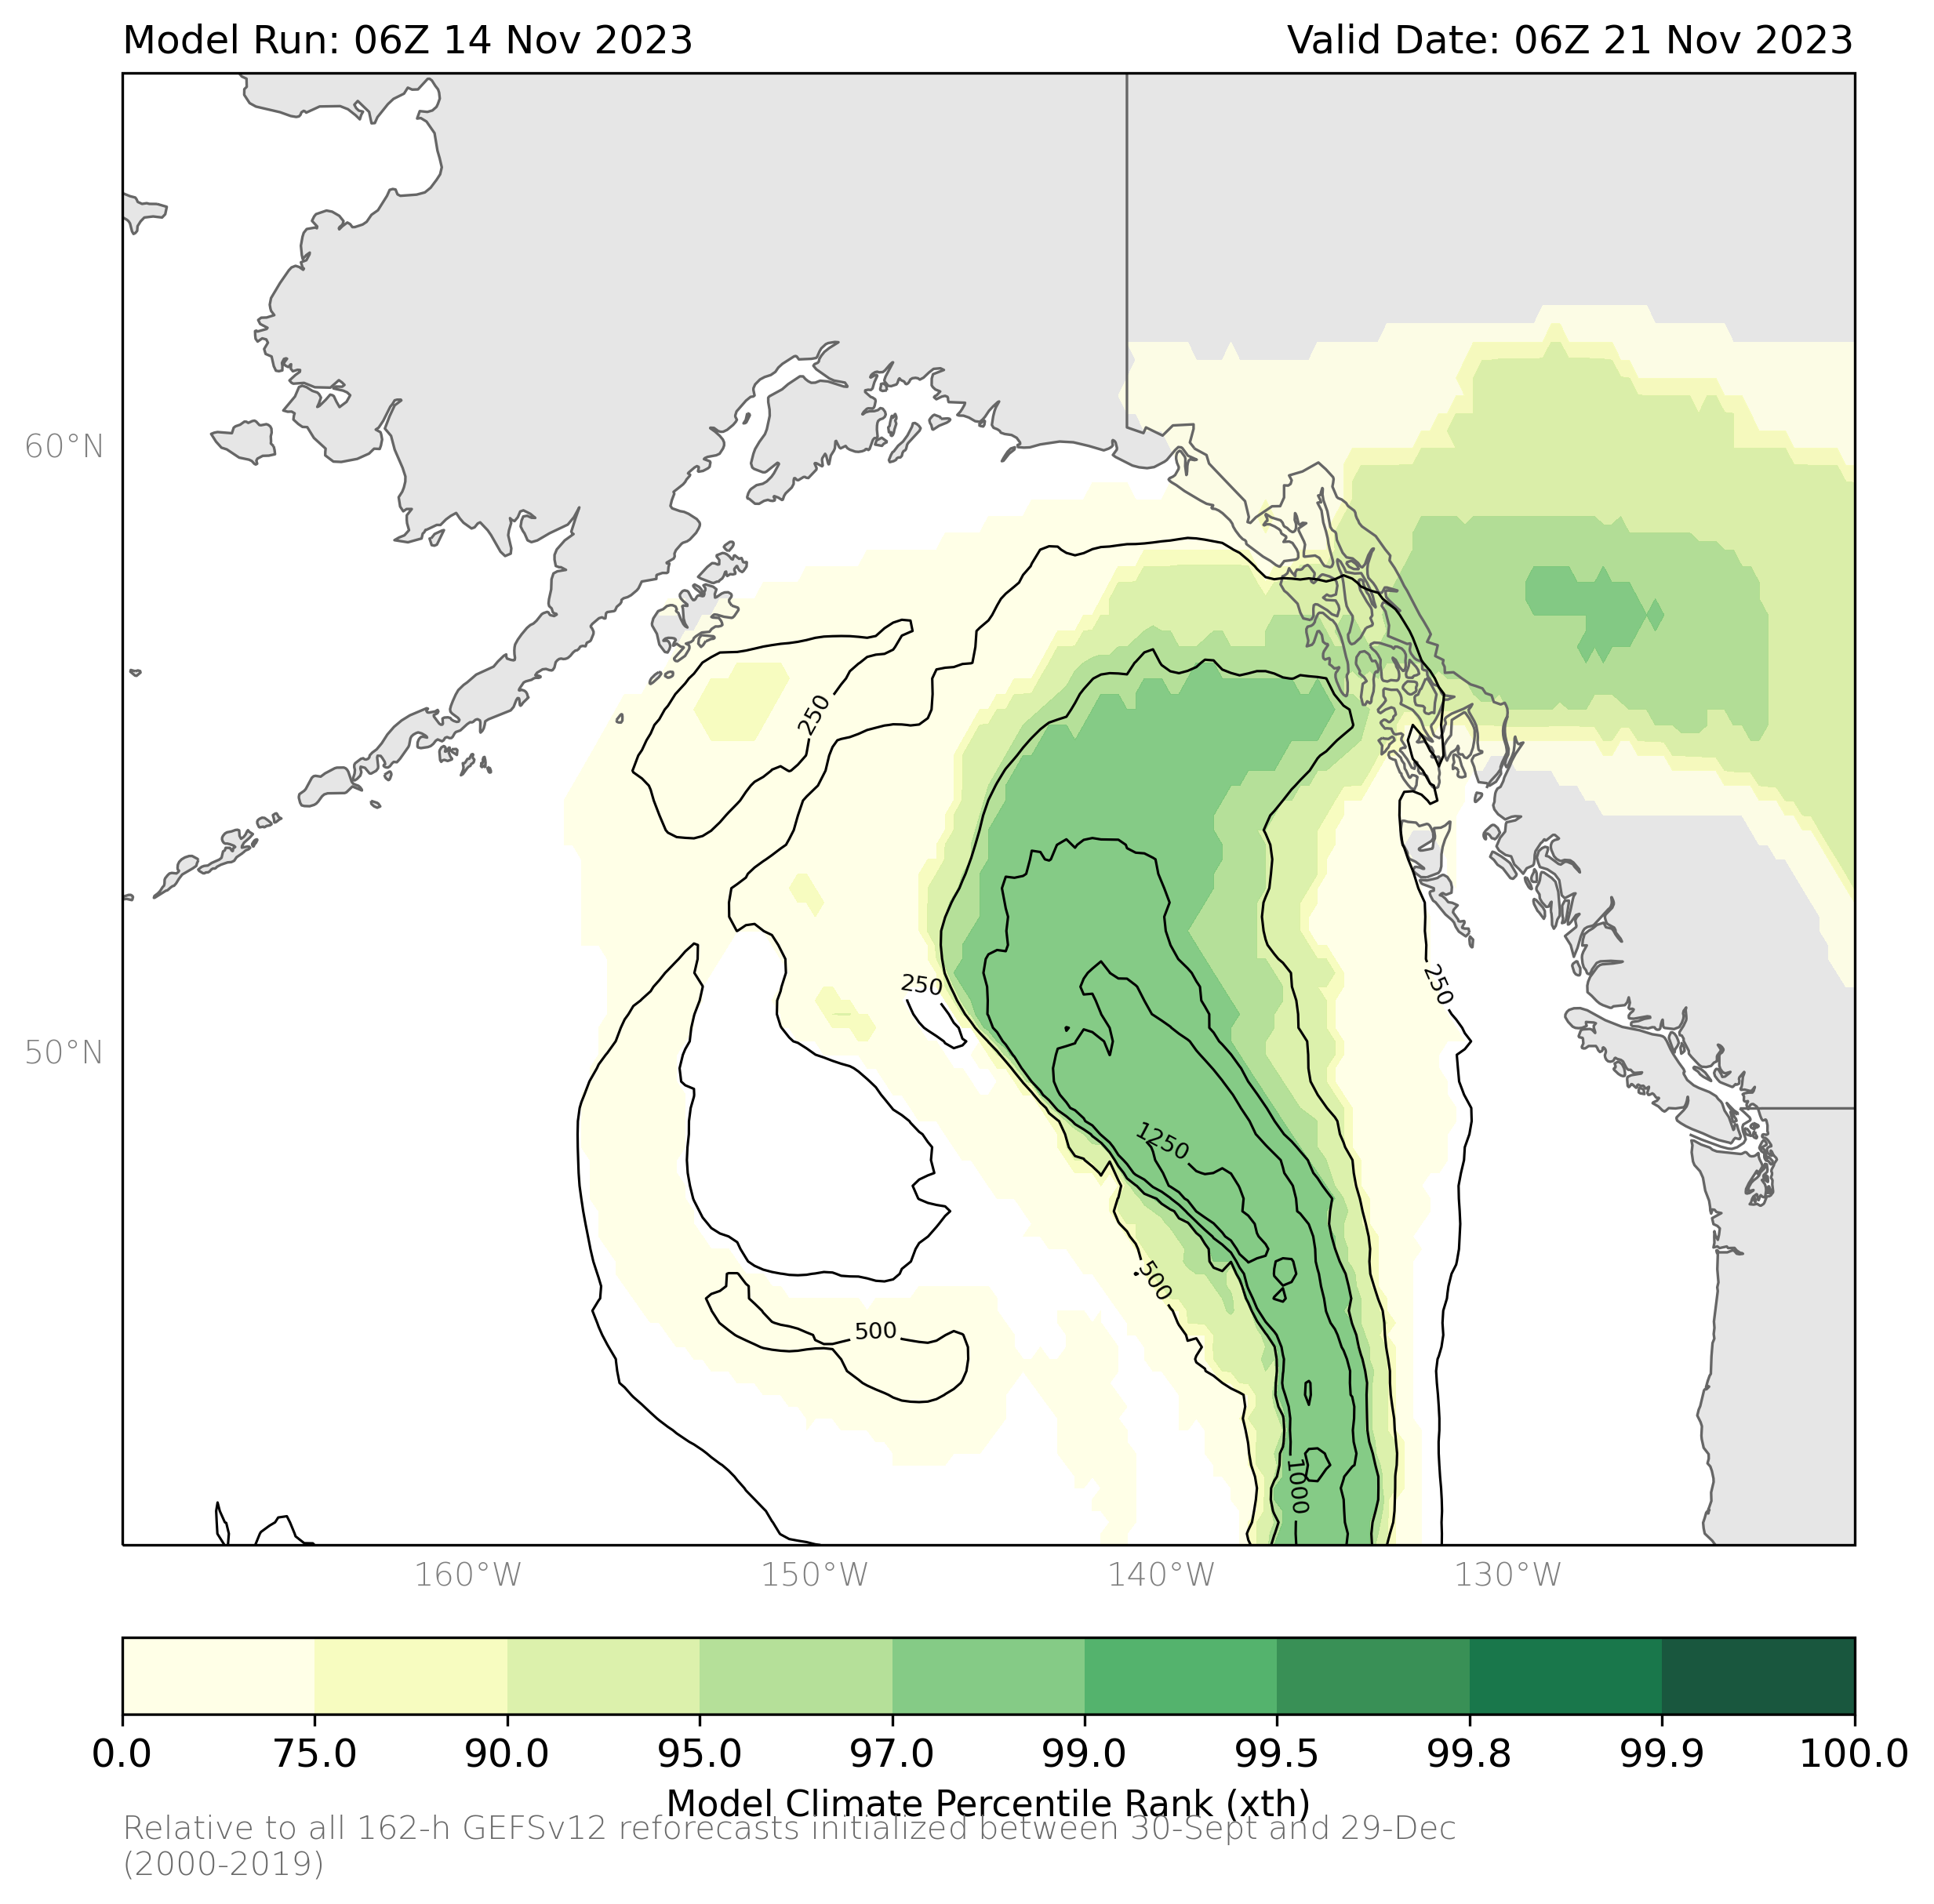

In [22]:
# Create figure
fig = plt.figure(figsize=(9.5, 10))
fig.dpi = 300
fname = path_to_figs + 'test_ivt_mclimate_nov14_F162'
fmt = 'png'

nrows = 3
ncols = 1

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05, 0.05], width_ratios = [1], wspace=0.05, hspace=0.1)
## use gs[rows index, columns index] to access grids

###################
### CLIMATOLOGY ###
###################

ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
    
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)

# Contour Filled
data = test.ivt_mclimate.values*100.
cmap, norm, bnds = ccmap.cmap('mclimate')
cf = ax.contourf(lons, lats, data, transform=datacrs,
                 levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')

# Contour Lines
clevs = np.arange(250., 2100., 250.)
cs = ax.contour(lons, lats, forecast.IVT, transform=datacrs,
                 levels=clevs, colors='k',
                 linewidths=0.75, linestyles='solid')
plt.clabel(cs, **kw_clabels)

# Add color bar
cbax = plt.subplot(gs[1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('Model Climate Percentile Rank (xth)', fontsize=11)
cb.ax.tick_params(labelsize=12)

ax.set_title('Model Run: 06Z 14 Nov 2023', loc='left', fontsize=12)
ax.set_title('Valid Date: 06Z 21 Nov 2023', loc='right', fontsize=12)

txt = 'Relative to all 162-h GEFSv12 reforecasts initialized between 30-Sept and 29-Dec (2000-2019)'
ann_ax = fig.add_subplot(gs[-1, 0])
ann_ax.axis('off')
ann_ax.annotate(textwrap.fill(txt, 90), # this is the text
           (0, 0.3), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,-15), # distance from text to points (x,y)
            ha='left', # horizontal alignment can be left, right or center
            **kw_ticklabels)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()